In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import LSTM, Dense, Reshape
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
start = datetime.datetime(2002, 1, 1)
end = datetime.datetime.today()

tickers = pd.read_csv("omx_tickers.csv", header=None) # as of 2021-03-01
tickers = list(tickers[0])
for i in range(len(tickers)):
    tickers[i] = tickers[i].replace(" ", "-") + ".ST"
print(len(tickers), tickers)

386 ['8TRA.ST', 'AAK.ST', 'ABB.ST', 'ADDT-B.ST', 'AF-B.ST', 'ALFA.ST', 'ALIV-SDB.ST', 'AM1S.ST', 'ARION-SDB.ST', 'ARJO-B.ST', 'ASSA-B.ST', 'ATCO-A.ST', 'ATCO-B.ST', 'ATRLJ-B.ST', 'AXFO.ST', 'AZA.ST', 'AZN.ST', 'BALD-B.ST', 'BEIJ-B.ST', 'BETS-B.ST', 'BHG.ST', 'BILL.ST', 'BOL.ST', 'BRAV.ST', 'BURE.ST', 'CAST.ST', 'CATE.ST', 'CINT.ST', 'DOM.ST', 'EKTA-B.ST', 'ELUX-A.ST', 'ELUX-B.ST', 'EPI-A.ST', 'EPI-B.ST', 'EPRO-B.ST', 'EQT.ST', 'ERIC-A.ST', 'ERIC-B.ST', 'ESSITY-A.ST', 'ESSITY-B.ST', 'EVO.ST', 'FABG.ST', 'FOI-B.ST', 'FPAR-A.ST', 'FPAR-D.ST', 'FPAR-PREF.ST', 'GETI-B.ST', 'HEXA-B.ST', 'HM-B.ST', 'HOLM-A.ST', 'HOLM-B.ST', 'HPOL-B.ST', 'HUFV-A.ST', 'HUSQ-A.ST', 'HUSQ-B.ST', 'ICA.ST', 'INDT.ST', 'INDU-A.ST', 'INDU-C.ST', 'INTRUM.ST', 'INVE-A.ST', 'INVE-B.ST', 'JM.ST', 'KIND-SDB.ST', 'KINV-A.ST', 'KINV-B.ST', 'KLED.ST', 'KLOV-A.ST', 'KLOV-B.ST', 'KLOV-PREF.ST', 'LATO-B.ST', 'LIFCO-B.ST', 'LOOMIS.ST', 'LUMI.ST', 'LUND-B.ST', 'LUNE.ST', 'MCOV-B.ST', 'MYCR.ST', 'NCC-A.ST', 'NCC-B.ST', 'NDA-SE.ST'

In [3]:
number_of_stocks = 3

In [4]:
OMX_raw = web.DataReader(["ABB.ST", "ERIC-B.ST", "ALFA.ST"], 'yahoo', start, end)

In [5]:
OMX = OMX_raw.copy()
OMX["Open"] = OMX["Open"] * OMX["Adj Close"] / OMX["Close"]
OMX.rename(columns={"Open":"Adj Open"}, inplace=True)
OMX["High"] = OMX["High"] * OMX["Adj Close"] / OMX["Close"]
OMX.rename(columns={"High":"Adj High"}, inplace=True)
OMX["Low"] = OMX["Low"] * OMX["Adj Close"] / OMX["Close"]
OMX.rename(columns={"Low":"Adj Low"}, inplace=True)
#OMX = OMX[["Adj Close", "Adj Open", "Adj High", "Adj Low", "Adj Close"]] # REMOVED VOLUME
OMX

Attributes   Adj Close                               Close              \
Symbols         ABB.ST   ERIC-B.ST     ALFA.ST      ABB.ST   ERIC-B.ST   
Date                                                                     
2002-01-01   75.241837  135.631348         NaN   80.192078  205.835617   
2002-01-02   75.614342  133.251862         NaN   80.589073  202.224472   
2002-01-03   81.946571  141.580109         NaN   87.337906  214.863495   
2002-01-04   84.553955  142.769882         NaN   90.116844  216.669067   
2002-01-07   83.436501  142.769882         NaN   88.925873  216.669067   
...                ...         ...         ...         ...         ...   
2021-02-23  240.899994  104.349998  259.799988  240.899994  104.349998   
2021-02-24  244.699997  103.849998  264.299988  244.699997  103.849998   
2021-02-25  244.100006  106.150002  265.799988  244.100006  106.150002   
2021-02-26  241.899994  105.400002  261.299988  241.899994  105.400002   
2021-03-01  248.000000  107.900002  268.000000  248.000000  107.900002   

Attributes                Adj High                             Adj Low  \
Symbols        ALFA.ST      ABB.ST   ERIC-B.ST     ALFA.ST      ABB.ST   
Date                                                                     
2002-01-01         NaN   75.241837  135.631348         NaN   75.241837   
2002-01-02         NaN   77.104277  134.441608         NaN   74.124399   
2002-01-03         NaN   81.946571  141.580109         NaN   76.359305   
2002-01-04         NaN   84.926437  147.528880         NaN   81.574078   
2002-01-07         NaN   86.416370  145.149386         NaN   81.574076   
...                ...         ...         ...         ...         ...   
2021-02-23  259.799988  247.399994  106.050003  266.600006  238.100006   
2021-02-24  264.299988  245.199997  105.400002  265.700012  241.100006   
2021-02-25  265.799988  246.800003  106.800003  266.700012  243.100006   
2021-02-26  261.299988  244.699997  106.099998  263.299988  241.000000   
2021-03-01  268.000000  248.199997  108.250000  267.799988  243.800003   

Attributes                            Adj Open                          \
Symbols      ERIC-B.ST     ALFA.ST      ABB.ST   ERIC-B.ST     ALFA.ST   
Date                                                                     
2002-01-01  135.631348         NaN   75.241837  135.631348         NaN   
2002-01-02  132.062115         NaN   74.869371  132.062115         NaN   
2002-01-03  134.441618         NaN   76.359305  134.441618         NaN   
2002-01-04  140.390388         NaN   82.319049  145.149386         NaN   
2002-01-07  140.390388         NaN   85.671407  143.959639         NaN   
...                ...         ...         ...         ...         ...   
2021-02-23  103.099998  257.700012  247.000000  105.650002  263.500000   
2021-02-24  103.449997  258.500000  241.100006  104.400002  260.100006   
2021-02-25  104.699997  264.100006  246.000000  105.000000  265.299988   
2021-02-26  104.000000  259.700012  242.600006  105.150002  262.700012   
2021-03-01  106.099998  263.200012  243.800003  107.699997  263.399994   

Attributes     Volume                        
Symbols        ABB.ST   ERIC-B.ST   ALFA.ST  
Date                                         
2002-01-01        0.0         0.0       NaN  
2002-01-02  1051654.0   6226894.0       NaN  
2002-01-03  5094707.0  11113838.0       NaN  
2002-01-04  3175370.0  17202996.0       NaN  
2002-01-07  3394227.0  20875685.0       NaN  
...               ...         ...       ...  
2021-02-23  2220543.0   5886405.0  939993.0  
2021-02-24  1526122.0  32333646.0  978505.0  
2021-02-25  1370005.0   8381992.0  742172.0  
2021-02-26  1346241.0   6391238.0  477623.0  
2021-03-01  1181945.0   4982622.0  459640.0  

[4854 rows x 18 columns]

In [6]:
#OMX.columns = ["Next Adj Close", "Adj Open", "Adj High", "Adj Low", "Adj Close"]

In [7]:
OMX["Adj Open"] = OMX["Adj Open"]/OMX["Adj Close"]
OMX["Adj High"] = OMX["Adj High"]/OMX["Adj Close"]
OMX["Adj Low"] = OMX["Adj Low"]/OMX["Adj Close"]
N = OMX["Adj Close"]/OMX["Adj Close"].shift(1)
N = N.iloc[1:]
OMX["Adj Close"] = OMX["Adj Close"]/OMX["Adj Close"].shift(1)
N

Symbols,ABB.ST,ERIC-B.ST,ALFA.ST
Date,,,
2002-01-02,1.004951,0.982456,NaN
2002-01-03,1.083744,1.062500,NaN
2002-01-04,1.031818,1.008404,NaN
2002-01-07,0.986784,1.000000,NaN
2002-01-08,0.991072,0.950000,NaN
...,...,...,...
2021-02-23,0.972940,0.983506,0.990847
2021-02-24,1.015774,0.995208,1.017321
2021-02-25,0.997548,1.022147,1.005675


In [8]:
OMX = OMX.iloc[1:]
#OMX = OMX.stack()
OMX

Attributes Adj Close                           Close                          \
Symbols       ABB.ST ERIC-B.ST   ALFA.ST      ABB.ST   ERIC-B.ST     ALFA.ST   
Date                                                                           
2002-01-02  1.004951  0.982456       NaN   80.589073  202.224472         NaN   
2002-01-03  1.083744  1.062500       NaN   87.337906  214.863495         NaN   
2002-01-04  1.031818  1.008404       NaN   90.116844  216.669067         NaN   
2002-01-07  0.986784  1.000000       NaN   88.925873  216.669067         NaN   
2002-01-08  0.991072  0.950000       NaN   88.131889  205.835617         NaN   
...              ...       ...       ...         ...         ...         ...   
2021-02-23  0.972940  0.983506  0.990847  240.899994  104.349998  259.799988   
2021-02-24  1.015774  0.995208  1.017321  244.699997  103.849998  264.299988   
2021-02-25  0.997548  1.022147  1.005675  244.100006  106.150002  265.799988   
2021-02-26  0.990987  0.992935  0.983070  241.899994  105.400002  261.299988   
2021-03-01  1.025217  1.023719  1.025641  248.000000  107.900002  268.000000   

Attributes  Adj High                       Adj Low                      \
Symbols       ABB.ST ERIC-B.ST   ALFA.ST    ABB.ST ERIC-B.ST   ALFA.ST   
Date                                                                     
2002-01-02  1.019704  1.008929       NaN  0.980296  0.991071       NaN   
2002-01-03  1.000000  1.000000       NaN  0.931818  0.949580       NaN   
2002-01-04  1.004405  1.033333       NaN  0.964758  0.983333       NaN   
2002-01-07  1.035714  1.016667       NaN  0.977679  0.983333       NaN   
2002-01-08  1.018018  1.035088       NaN  0.995496  0.991228       NaN   
...              ...       ...       ...       ...       ...       ...   
2021-02-23  1.026982  1.016291  1.026174  0.988377  0.988021  0.991917   
2021-02-24  1.002043  1.014925  1.005297  0.985288  0.996148  0.978055   
2021-02-25  1.011061  1.006123  1.003386  0.995903  0.986340  0.993604   
2021-02-26  1.011575  1.006641  1.007654  0.996279  0.986717  0.993877   
2021-03-01  1.000806  1.003244  0.999254  0.983065  0.983318  0.982090   

Attributes  Adj Open                         Volume                        
Symbols       ABB.ST ERIC-B.ST   ALFA.ST     ABB.ST   ERIC-B.ST   ALFA.ST  
Date                                                                       
2002-01-02  0.990148  0.991071       NaN  1051654.0   6226894.0       NaN  
2002-01-03  0.931818  0.949580       NaN  5094707.0  11113838.0       NaN  
2002-01-04  0.973568  1.016667       NaN  3175370.0  17202996.0       NaN  
2002-01-07  1.026786  1.008333       NaN  3394227.0  20875685.0       NaN  
2002-01-08  1.009009  1.026316       NaN  1999472.0  20743623.0       NaN  
...              ...       ...       ...        ...         ...       ...  
2021-02-23  1.025322  1.012458  1.014242  2220543.0   5886405.0  939993.0  
2021-02-24  0.985288  1.005296  0.984109  1526122.0  32333646.0  978505.0  
2021-02-25  1.007784  0.989166  0.998119  1370005.0   8381992.0  742172.0  
2021-02-26  1.002894  0.997628  1.005358  1346241.0   6391238.0  477623.0  
2021-03-01  0.983065  0.998146  0.982836  1181945.0   4982622.0  459640.0  

[4853 rows x 18 columns]

In [9]:
scaler = MinMaxScaler((-1, 1))
data = np.concatenate((N.to_numpy(), OMX.to_numpy()), axis=1)
data = data[:, :-number_of_stocks] # removes volume
data = data[~np.isnan(data).any(axis=1)]
data = scaler.fit_transform(data)
data, data.shape

(array([[ 0.0830918 , -0.31601275,  0.21746555, ...,  0.04556212,
          0.36676725, -0.16472032],
        [ 0.16303653, -0.0244664 ,  0.37068961, ..., -0.15529158,
          0.21420302, -0.31885684],
        [ 0.17346205,  0.02784554,  0.34820748, ..., -0.18053357,
          0.10522889, -0.28815947],
        ...,
        [ 0.15830758,  0.06629045,  0.37232263, ..., -0.16935201,
          0.04974072, -0.29913107],
        [ 0.14565406, -0.05341974,  0.27627032, ..., -0.19206414,
          0.09308042, -0.2569094 ],
        [ 0.21167149,  0.0727315 ,  0.45715867, ..., -0.28416595,
          0.09573508, -0.38826967]]),
 (4681, 18))

In [10]:
X = []
Y = []
input_period = 21
output_period = 1
for i in range(input_period, data.shape[0]-output_period+1):
    X.append(data[(i-input_period):i, number_of_stocks:])
    Y.append(data[i:(i+output_period), :number_of_stocks])

X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(4660, 21, 15)
(4660, 1, 3)


In [11]:
split = 3000
trainX, trainY = X[:split, :], Y[:split, :]
valX, valY = X[split+output_period:, :], Y[split+output_period:, :] # + output_period so that they dont overlap

In [12]:
valX[10, :, -1], valY[9] # OK

(array([-0.20989361, -0.26426935, -0.17331951, -0.26376986, -0.37347983,
        -0.20503564, -0.38678462, -0.05922682, -0.20626223, -0.24147063,
        -0.29172697, -0.22676485, -0.35585473, -0.24853139, -0.23747379,
        -0.25549423, -0.25163787, -0.18420703, -0.22435431, -0.27320457,
        -0.30676987]),
 array([[ 0.15687858, -0.01233529,  0.36727348]]))

In [13]:
print(trainX.shape, trainY.shape)
print(valX.shape, valY.shape)

(3000, 21, 15) (3000, 1, 3)
(1659, 21, 15) (1659, 1, 3)


Epoch 1/10
94/94 [==============================] - 6s 61ms/step - loss: 0.0142 - mae: 0.0763 - val_loss: 0.0048 - val_mae: 0.0456
Epoch 2/10
94/94 [==============================] - 5s 55ms/step - loss: 0.0092 - mae: 0.0602 - val_loss: 0.0048 - val_mae: 0.0454
Epoch 3/10
94/94 [==============================] - 3s 36ms/step - loss: 0.0093 - mae: 0.0613 - val_loss: 0.0051 - val_mae: 0.0487
Epoch 4/10
94/94 [==============================] - 3s 36ms/step - loss: 0.0090 - mae: 0.0602 - val_loss: 0.0048 - val_mae: 0.0449
Epoch 5/10
94/94 [==============================] - 4s 37ms/step - loss: 0.0090 - mae: 0.0593 - val_loss: 0.0046 - val_mae: 0.0429
Epoch 6/10
94/94 [==============================] - 3s 37ms/step - loss: 0.0089 - mae: 0.0588 - val_loss: 0.0048 - val_mae: 0.0464
Epoch 7/10
94/94 [==============================] - 4s 39ms/step - loss: 0.0089 - mae: 0.0589 - val_loss: 0.0050 - val_mae: 0.0461
Epoch 8/10
94/94 [==============================] - 8s 86ms/step - loss: 0.0090 - m

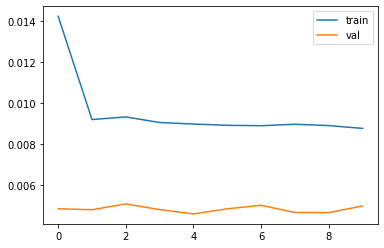

In [22]:
time_steps = trainX.shape[1]
features = trainX.shape[2]

lstm_model = Sequential()

lstm_model.add(LSTM(100, return_sequences=False, input_shape=(time_steps, features)))
lstm_model.add(Dense(output_period*number_of_stocks))
lstm_model.add(Reshape([output_period, number_of_stocks]))

lstm_model.compile(loss="mse", optimizer="adam", metrics=["mae"]) # mae vs mse?

history = lstm_model.fit(trainX, trainY, epochs=10, validation_data=(valX, valY))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [23]:
pred_val = lstm_model.predict(valX)
print(pred_val.shape, valY.shape)
for i in range(output_period):
    print(i+1, np.corrcoef(pred_val[:, i, 0], valY[:, i, 0])[0][1])
    print(i+1, np.corrcoef(pred_val[:, i, 1], valY[:, i, 1])[0][1])
    print(i+1, np.corrcoef(pred_val[:, i, 2], valY[:, i, 2])[0][1])

(1659, 1, 3) (1659, 1, 3)
1 0.041116063588965315
1 0.039668821575681704
1 0.008572313876921422


In [24]:
'''for i in range(5):
    start = i*300
    y = valY[start, :, 0]
    p = pred_val[start, :, 0] # pred gives + 1
    plt.figure(i)
    plt.plot(y, c="g")
    plt.plot(p, c="y")'''

'for i in range(5):\n    start = i*300\n    y = valY[start, :, 0]\n    p = pred_val[start, :, 0] # pred gives + 1\n    plt.figure(i)\n    plt.plot(y, c="g")\n    plt.plot(p, c="y")'

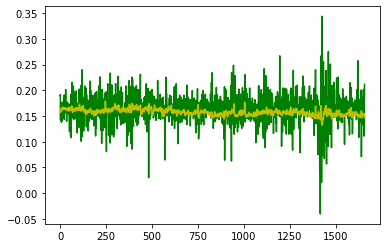

In [25]:
plt.plot(valY[:, 0, 0], c="g")
plt.plot(pred_val[:, 0, 0], c="y")

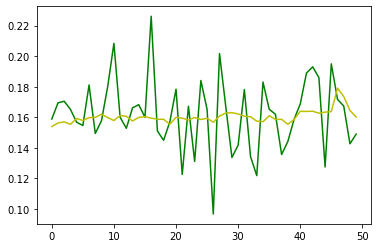

In [26]:
plt.plot(valY[200:250, 0, 0], c="g")
plt.plot(pred_val[200:250, 0, 0], c="y")

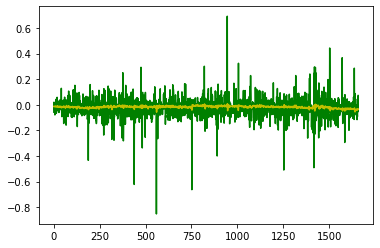

In [27]:
plt.plot(valY[:, 0, 1], c="g")
plt.plot(pred_val[:, 0, 1], c="y")

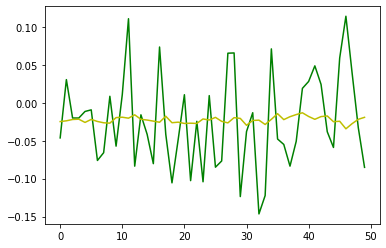

In [28]:
plt.plot(valY[200:250, 0, 1], c="g")
plt.plot(pred_val[200:250, 0, 1], c="y")

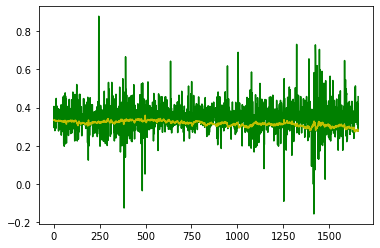

In [29]:
plt.plot(valY[:, 0, 2], c="g")
plt.plot(pred_val[:, 0, 2], c="y")

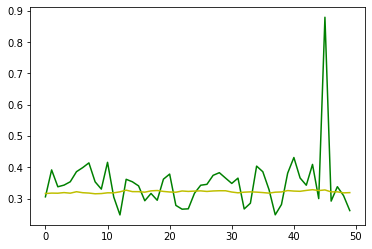

In [30]:
plt.plot(valY[200:250, 0, 2], c="g")
plt.plot(pred_val[200:250, 0, 2], c="y")